# ARIMA

The Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard statistical model for time series forecast and analysis.
  
The authors Box and Jenkins also suggest a process for identifying, estimating, and checking models for a specific time series dataset. This process is now referred to as the Box-Jenkins Method.
  
We will be using concepts from this method such as Autocorrelation, Partial Autocorrelation and Akaike Information Criterion to tune the hyperparameters of the model as well as help evaluate the usefulness of this machine learning model.   
  
Although the dataset provides us with numerous varialbes, the profit or loss calculation of a stock is usually determined by the closing price, thus we will consider the closing price as the target variable. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pandas import read_csv
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm

### Import Data

              Close
Date               
1984-09-07  0.42388
1984-09-10  0.42134
1984-09-11  0.42902
1984-09-12  0.41618
1984-09-13  0.43927


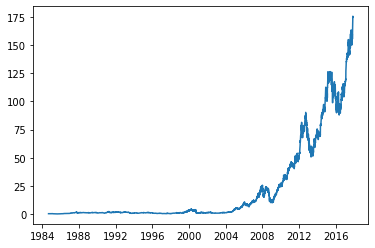

In [2]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
stock = 'aapl' 
path = 'data/Stocks/'
df = read_csv(path +'%s.us.txt'%stock, header=0, parse_dates=[0], index_col=0, date_parser=parser)
df.drop(columns=['OpenInt','Open','High','Low','Volume'], inplace = True)
print(df.head())
plt.plot(df['Close'])

### Setting parameters for train test split

In [3]:
train_test_split = 0.80

# <ins> Predicting t+1 </ins>

# Splitting of data

In [4]:
# split into train and test sets
X = df.values
size = int(len(X) * train_test_split)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

# Dickey-Fuller Test

The Dickey-Fuller test tests the null hypothesis that the data is non-stationary in an autoregressive time series model.   
For the ARIMA model to be used, the data has to be stationary and we achieve this by performing differencing. 

p-value > 0.05: Fail to reject the null hypothesis (H0), the data is non-stationary.  
p-value <= 0.05: Reject the null hypothesis (H0), the data is stationary.

In [5]:
X = pd.Series(train.flatten('F'))
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.782586
p-value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In this case, the p-value > 0.05 and thus clearly at least one order of differencing is needed to stationarize this series.  
We perform one order of differencing.

ADF Statistic: -11.815507
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


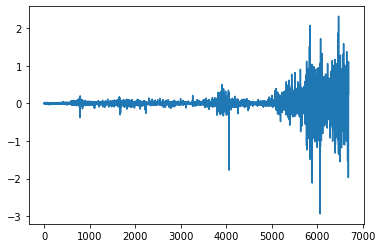

In [6]:
first_diff = X - X.shift(1)
first_diff = first_diff.dropna(inplace = False)
plt.plot(first_diff)
result = adfuller(first_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

After one order of differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

# Autocorrelation

We will be using the Box-Jenkins model to analyze the input parameters for Autoregressive integrated moving average (ARIMA) where the inputs are p, d, q.    
  
p : the order of the Auto Regressive (AR) term    
d : the minimum number of differencing needed to make the series stationar  
q : the order of the Moving Average (MA) term  


Firstly, we will be using the first order differenced values to try to find the AR term by inspecting the Partial Autocorrelation (PACF) plot.

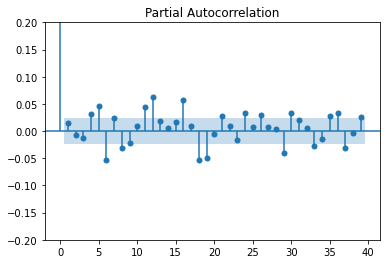

In [7]:
plot_pacf(first_diff, alpha=.05)
plt.ylim(-0.2, 0.2)
plt.show()

Next, we try to find the MA term by insepcting the Autocorrelation (ACF) plot.

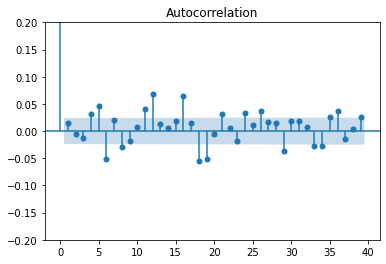

In [8]:
plot_acf(first_diff, alpha=.05)
plt.ylim(-0.2, 0.2)
plt.show()

Our analysis here will be based of the Box-Jenkins methods which describe methods for model identification. 

First we notice that neither the autocorrelation or partial autocorrelation graphs cut off, which suggest that we should use a mixed model instead of purely AR or MA.

Next, when we analyze the first few autocorrelation and partial autocorrelation values, we are not able to find any large values above the significance threshhold to suggest an appropriate p and q value for our model. This also suggests that the model follows a white noise pattern which would be difficult to model. 
  
Therefore a more conclusive way to deteremine the model parameters would be to make use of the pmdarima package auto ARIMA function which performs stepwise search to minimize Akaike Information Criterion value.

In [9]:
auto = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto.order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1764.402, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1763.767, Time=0.95 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1763.784, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1760.178, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1761.850, Time=1.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.723 seconds
(0, 1, 0)


# ARIMA

Since we will be constantly updating our model everytime a new closing price for a stock comes out, we will be performing walk-forward validation on the generated ARIMA model.
At each step, the model predicts the next step value and updates the model with the actual value by using a expanding window.  

In [10]:
model = auto

def forecast_one_step():
    fc = model.predict(n_periods=1)
    return fc.tolist()[0]

predictions1 = []

for t in range(len(test)):
    fc = forecast_one_step()
    predictions1.append(fc)
    model.update(test[t])

As we can see above, the root mean square error of the ARIMA model is 1.396 while the error of the persistent model is 1.952 which means it has a higher accuracy. 

In [12]:
temp_test = test.copy()
result_df = pd.DataFrame(temp_test , columns =['Initial'])
result_df['Actual'] = test
result_df['Initial'] = result_df['Initial'].shift(1, axis = 0)
result_df['Predicted'] = predictions1
result_df['Initial'][0] = train[len(train)-1]
result_df['Act_Change'] = result_df.apply(lambda row: row['Actual'] - row['Initial'] , axis = 1)
result_df['Pred_Change'] = result_df.apply(lambda row: row['Predicted'] - row['Initial'] , axis = 1)

result_df.head(5)

,Initial,Actual,Predicted,Act_Change,Pred_Change
0,43.696,43.436,43.702468,-0.260,0.006468
1,43.436,44.179,43.442424,0.743,0.006424
2,44.179,45.019,44.185533,0.840,0.006533
3,45.019,44.877,45.025658,-0.142,0.006658
4,44.877,44.945,44.883636,0.068,0.006636


# Evaluation of results

Test RMSE: 1.396


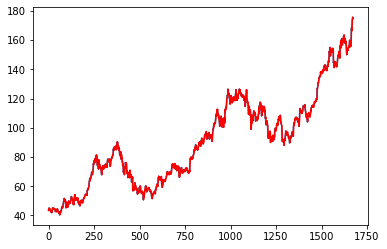

In [31]:
rmse = np.sqrt(mean_squared_error(result_df['Actual'], result_df['Predicted']))
print('Test RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions1, color='red')
plt.show()

In [27]:
tp = 0
tn = 0
fp = 0
fn = 0

for index, row in result_df.iterrows():
    if (row['Pred_Change'] > 0):
        if (row['Act_Change'] > 0):
            tp += 1
        else:
            fp += 1
    else:
        if (row['Act_Change'] > 0):
            fn += 1
        else:
            tn += 1
            
if (((fn + tp)==0) | ((fp + tp)==0)):
    print('no data available')
else:         
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print('Test accuracy: %.3f' % accuracy)
    recall = tp/(fn + tp)
    print('Test recall: %.3f' % recall)
    precision = tp/(fp + tp)
    print('Test precision: %.3f' % precision)
    f1 = 2/((1/precision)+(1/recall))
    print('Test f1 score: %.3f' % f1)


Test accuracy: 0.519
Test recall: 1.000
Test precision: 0.519
Test f1 score: 0.684


### Average Expected Gain Per Purchase

In [13]:
profit = 0;
counter = 0
for index, row in result_df.iterrows():
    if (row['Pred_Change'] > 0):
        profit += row['Act_Change']
        counter += 1
if (counter == 0):
    print(counter)
else:
    print(profit/counter)

0.07828690974297668


# <ins> Predicting t+5 </ins>

In [14]:
auto = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto.order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1764.402, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1763.767, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1763.784, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1760.178, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1761.850, Time=1.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.619 seconds
(0, 1, 0)


In [15]:
model = auto

def forecast_one_step():
    fc = model.predict(n_periods=5)
    return fc.tolist()[0]

predictions5 = []

for t in range(len(test)):
    fc = forecast_one_step()
    predictions5.append(fc)
    model.update(test[t])

In [17]:
temp_test5 = test.copy()
result_df5 = pd.DataFrame(temp_test5 , columns =['Initial'])
result_df5['Initial'] = result_df5['Initial'].shift(1, axis =0)
result_df5['Initial'][0] = train[len(train)-1]
result_df5.drop(result_df5.tail(4).index,inplace=True)
result_df5['Actual'] = test[4:]
result_df5['Predicted'] = predictions5[:len(predictions5)-4]
result_df5['Act_Change'] = result_df5.apply(lambda row: row['Actual'] - row['Initial'] , axis = 1)
result_df5['Pred_Change'] = result_df5.apply(lambda row: row['Predicted'] - row['Initial'] , axis = 1)

result_df5.head(10)

,Initial,Actual,Predicted,Act_Change,Pred_Change
0,43.696,44.945,43.702468,1.249,0.006468
1,43.436,44.646,43.442424,1.210,0.006424
2,44.179,44.631,44.185533,0.452,0.006533
3,45.019,44.126,45.025658,-0.893,0.006658
4,44.877,43.695,44.883636,-1.182,0.006636
5,44.945,43.401,44.951643,-1.544,0.006643
6,44.646,43.291,44.652600,-1.355,0.006600
7,44.631,43.294,44.637598,-1.337,0.006598
8,44.126,42.908,44.132520,-1.218,0.006520
9,43.695,42.364,43.701462,-1.331,0.006462


# Evaluation of results

Test RMSE: 3.139


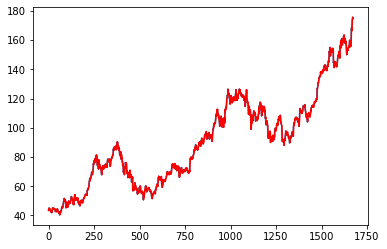

In [29]:
rmse = np.sqrt(mean_squared_error(result_df5['Actual'], result_df5['Predicted']))
print('Test RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions1, color='red')
plt.show()

In [25]:
tp = 0
tn = 0
fp = 0
fn = 0

for index, row in result_df5.iterrows():
    if (row['Pred_Change'] > 0):
        if (row['Act_Change'] > 0):
            tp += 1
        else:
            fp += 1
    else:
        if (row['Act_Change'] > 0):
            fn += 1
        else:
            tn += 1
            
if (((fn + tp)==0) | ((fp + tp)==0)):
    print('no data available')
else:         
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print('Test accuracy: %.3f' % accuracy)
    recall = tp/(fn + tp)
    print('Test recall: %.3f' % recall)
    precision = tp/(fp + tp)
    print('Test precision: %.3f' % precision)
    f1 = 2/((1/precision)+(1/recall))
    print('Test f1 score: %.3f' % f1)


Test accuracy: 0.557
Test recall: 1.000
Test precision: 0.557
Test f1 score: 0.716


In [26]:
profit = 0;
counter = 0
for index, row in result_df5.iterrows():
    if (row['Pred_Change'] > 0):
        profit += row['Act_Change']
        counter += 1
if (counter == 0):
    print(counter)
else:
    print(profit/counter)

0.3907327741162379


# <ins> Predicting t+30 </ins>

In [19]:
auto = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto.order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1764.402, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1763.767, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1763.784, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1760.178, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1761.850, Time=1.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.736 seconds
(0, 1, 0)


In [20]:
model = auto

def forecast_one_step():
    fc = model.predict(n_periods=30)
    return fc.tolist()[0]

predictions30 = []

for t in range(len(test)):
    fc = forecast_one_step()
    predictions30.append(fc)
    model.update(test[t])

In [21]:
temp_test30 = test.copy()
result_df30 = pd.DataFrame(temp_test30 , columns =['Initial'])
result_df30['Initial'] = result_df30['Initial'].shift(1, axis =0)
result_df30['Initial'][0] = train[len(train)-1]
result_df30.drop(result_df30.tail(29).index,inplace=True)
result_df30['Actual'] = test[29:]
result_df30['Predicted'] = predictions30[:len(predictions30)-29]
result_df30['Act_Change'] = result_df30.apply(lambda row: row['Actual'] - row['Initial'] , axis = 1)
result_df30['Pred_Change'] = result_df30.apply(lambda row: row['Predicted'] - row['Initial'] , axis = 1)

result_df30.head(10)

,Initial,Actual,Predicted,Act_Change,Pred_Change
0,43.696,44.766,43.702468,1.070,0.006468
1,43.436,44.405,43.442424,0.969,0.006424
2,44.179,44.392,44.185533,0.213,0.006533
3,45.019,44.515,45.025658,-0.504,0.006658
4,44.877,44.752,44.883636,-0.125,0.006636
5,44.945,44.466,44.951643,-0.479,0.006643
6,44.646,44.382,44.652600,-0.264,0.006600
7,44.631,43.605,44.637598,-1.026,0.006598
8,44.126,42.682,44.132520,-1.444,0.006520
9,43.695,43.048,43.701462,-0.647,0.006462


# Evaluation of results

Test RMSE: 8.133


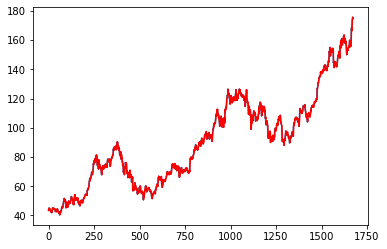

In [30]:
rmse = np.sqrt(mean_squared_error(result_df30['Actual'], result_df30['Predicted']))
print('Test RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions1, color='red')
plt.show()

In [28]:
tp = 0
tn = 0
fp = 0
fn = 0

for index, row in result_df30.iterrows():
    if (row['Pred_Change'] > 0):
        if (row['Act_Change'] > 0):
            tp += 1
        else:
            fp += 1
    else:
        if (row['Act_Change'] > 0):
            fn += 1
        else:
            tn += 1
            
if (((fn + tp)==0) | ((fp + tp)==0)):
    print('no data available')
else:         
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print('Test accuracy: %.3f' % accuracy)
    recall = tp/(fn + tp)
    print('Test recall: %.3f' % recall)
    precision = tp/(fp + tp)
    print('Test precision: %.3f' % precision)
    f1 = 2/((1/precision)+(1/recall))
    print('Test f1 score: %.3f' % f1)


Test accuracy: 0.607
Test recall: 1.000
Test precision: 0.607
Test f1 score: 0.755


In [22]:
profit = 0;
counter = 0
for index, row in result_df30.iterrows():
    if (row['Pred_Change'] > 0):
        profit += row['Act_Change']
        counter += 1
if (counter == 0):
    print(counter)
else:
    print(profit/counter)

2.1425182481751808
